In [1]:
# Clone repository
%cd /content
!rm -rf Deep_Learning_Project_Gil_Alon
!git clone https://github.com/gil-attar/Deep_Learning_Project_Gil_Alon.git
%cd Deep_Learning_Project_Gil_Alon

/content
Cloning into 'Deep_Learning_Project_Gil_Alon'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 173 (delta 81), reused 117 (delta 37), pack-reused 0 (from 0)
Receiving objects: 100% (173/173), 1.16 MiB | 5.74 MiB/s, done.
Resolving deltas: 100% (81/81), done.
/content/Deep_Learning_Project_Gil_Alon


In [2]:
# Install dependencies
!pip install roboflow pyyaml pillow -q

In [3]:
import os
os.environ["ROBOFLOW_API_KEY"] = "zEF9icmDY2oTcPkaDcQY"

# Download dataset
!python scripts/download_dataset.py --output_dir data/raw

# Build evaluation index (creates test_index.json)
!python scripts/build_evaluation_index.py --dataset_root data/raw --output_dir data/processed

DOWNLOADING FOOD INGREDIENTS DATASET
  Workspace: gaworkspace-utcbg
  Project:   food-ingredients-dataset-2-rewtd
  Version:   1
  Output:    data/raw
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to FOOD-INGREDIENTS-dataset-2-1 in yolov8:: 100% 3980/3980 [00:00<00:00, 4996.23it/s]
Downloaded to: /content/Deep_Learning_Project_Gil_Alon/FOOD-INGREDIENTS-dataset-2-1
  Moved train/
  Moved valid/
  Moved test/
  Copied data.yaml

DOWNLOAD COMPLETE
  train: 1384 images
  valid: 200 images
  test: 400 images

✓ Dataset saved to data/raw

IMPORTANT: data/raw/ is READ-ONLY. Never modify these files.

Next step: Run build_evaluation_index.py to create evaluation artifacts.
BUILD EVALUATION INDEX (Step 2)
  Dataset root: data/raw
  Output dir:   data/processed
  Seed:         42

1. Loading class names...
   Found 26 classes

2. Building split manifest...
   Train: 1384 images
   Valid: 200 images
   Test:  400 images
   Saved: data/processed/splits/

In [4]:
# Generate synthetic occlusions
!python scripts/generate_synthetic_occlusions.py \
    --test_index data/processed/evaluation/test_index.json \
    --images_dir data/raw/test/images \
    --labels_dir data/raw/test/labels \
    --output_dir data/synthetic_occlusion \
    --levels 0.2,0.4,0.6 \
    --seed 42

GENERATE SYNTHETIC OCCLUSIONS
  Test index:  data/processed/evaluation/test_index.json
  Images dir:  data/raw/test/images
  Output dir:  data/synthetic_occlusion
  Levels:      [0.2, 0.4, 0.6]
  Seed:        42

Loaded 400 test images from index

Processing level_020 (20% occlusion)...
  ✓ Created 400 images, 856 boxes occluded

Processing level_040 (40% occlusion)...
  ✓ Created 400 images, 856 boxes occluded

Processing level_060 (60% occlusion)...
  ✓ Created 400 images, 856 boxes occluded

SYNTHETIC OCCLUSION TEST SETS COMPLETE

Created test sets:
  ✓ data/synthetic_occlusion/level_020
  ✓ data/synthetic_occlusion/level_040
  ✓ data/synthetic_occlusion/level_060

Manifest: data/synthetic_occlusion/occlusion_manifest.json

NEXT: Run evaluation on each test set

Example usage in evaluation:

    # For each occlusion level:
    model = YOLO('models/yolov8n_baseline.pt')
    results = model.val(data='data/synthetic_occlusion/level_020/data.yaml')
    
    # Compare mAP across levels t

In [5]:
# Verify output structure
!echo "=== Output Structure ==="
!ls -la data/synthetic_occlusion/
!echo ""
!echo "=== Level 020 (20% occlusion) ==="
!ls data/synthetic_occlusion/level_020/images/ | head -5
!echo ""
!echo "=== Image counts ==="
!echo "Level 020: $(ls data/synthetic_occlusion/level_020/images/ | wc -l) images"
!echo "Level 040: $(ls data/synthetic_occlusion/level_040/images/ | wc -l) images"
!echo "Level 060: $(ls data/synthetic_occlusion/level_060/images/ | wc -l) images"

=== Output Structure ===
total 24
drwxr-xr-x 5 root root 4096 Jan 10 12:22 .
drwxr-xr-x 5 root root 4096 Jan 10 12:22 ..
drwxr-xr-x 4 root root 4096 Jan 10 12:22 level_020
drwxr-xr-x 4 root root 4096 Jan 10 12:22 level_040
drwxr-xr-x 4 root root 4096 Jan 10 12:22 level_060
-rw-r--r-- 1 root root  620 Jan 10 12:22 occlusion_manifest.json

=== Level 020 (20% occlusion) ===
0001498f7974f5602099de9ca25a3973_jpg.rf.31e45f9a0263e1fd57e3da78fa6a8e16.jpg
005_jpg.rf.2272b79e24ebf4e8efe5e7ebf1cf110f.jpg
009_jpg.rf.f507dbf677c543a4c86e84945d249009.jpg
011_jpg.rf.6ccd208f6fa9569d51d3cfc6a40ceee2.jpg
024_PNG_jpg.rf.0e11c3d77797462524bde176f505ceb0.jpg

=== Image counts ===
Level 020: 400 images
Level 040: 400 images
Level 060: 400 images


## Visualize 10 Examples Per Level

Compare original vs 20% vs 40% vs 60% occlusion for the same images.

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random

# Get 10 random test images
original_dir = Path('data/raw/test/images')
all_images = sorted(original_dir.glob('*.jpg'))

random.seed(42)
sample_images = random.sample(all_images, min(10, len(all_images)))

print(f"Selected {len(sample_images)} images for visualization")

Selected 10 images for visualization


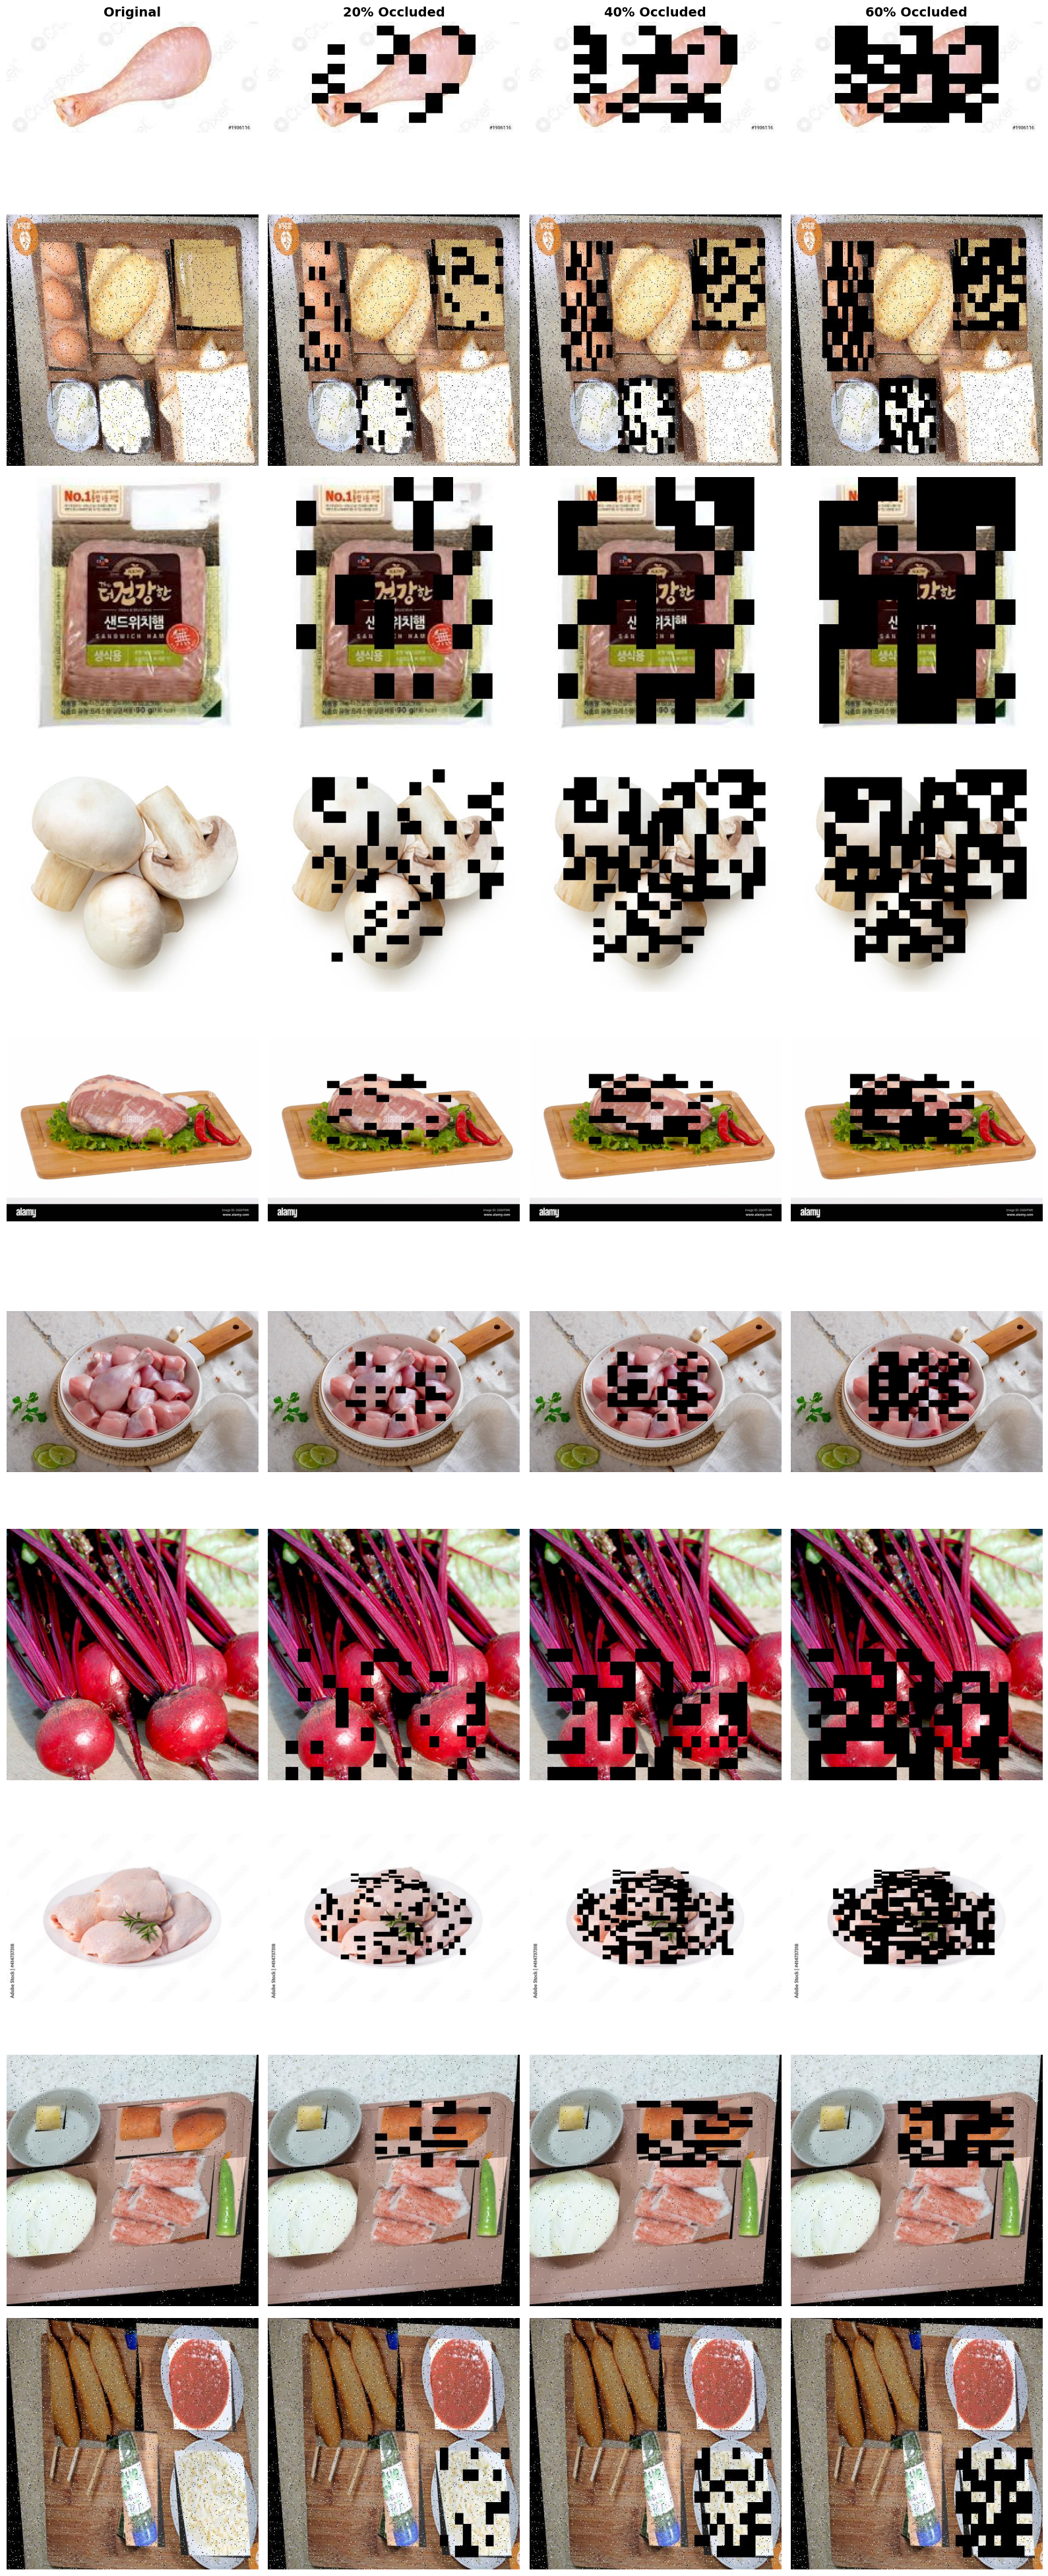


✓ Saved to evaluation/synthetic_occlusion_examples.png


In [7]:
# Visualize: 10 rows x 4 columns (original, 20%, 40%, 60%)
fig, axes = plt.subplots(10, 4, figsize=(16, 40))

levels = ['original', 'level_020', 'level_040', 'level_060']
titles = ['Original', '20% Occluded', '40% Occluded', '60% Occluded']

for row, img_path in enumerate(sample_images):
    filename = img_path.name
    
    for col, (level, title) in enumerate(zip(levels, titles)):
        if level == 'original':
            path = img_path
        else:
            path = Path(f'data/synthetic_occlusion/{level}/images/{filename}')
        
        if path.exists():
            img = Image.open(path)
            axes[row, col].imshow(img)
        else:
            axes[row, col].text(0.5, 0.5, 'Not found', ha='center', va='center')
        
        if row == 0:
            axes[row, col].set_title(title, fontsize=14, fontweight='bold')
        
        axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('evaluation/synthetic_occlusion_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved to evaluation/synthetic_occlusion_examples.png")

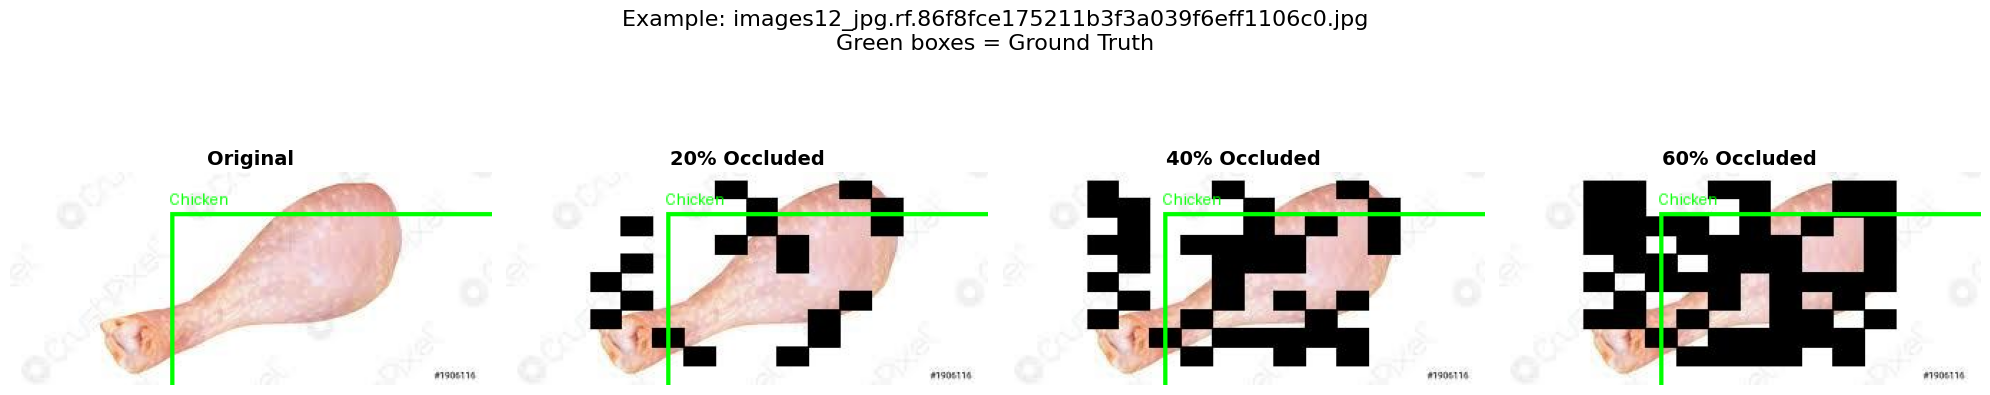


Image: images12_jpg.rf.86f8fce175211b3f3a039f6eff1106c0.jpg
Difficulty: easy
Objects: 1
Classes: ['Chicken']


In [8]:
# Detailed view: Show bounding boxes on one example
import json
from PIL import ImageDraw

# Load test index to get bounding boxes
with open('data/processed/evaluation/test_index.json', 'r') as f:
    test_index = json.load(f)

# Pick first sample image
sample_filename = sample_images[0].name
sample_id = sample_images[0].stem

# Find this image in the index
img_data = None
for img in test_index['images']:
    if img['image_filename'] == sample_filename:
        img_data = img
        break

if img_data:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for col, (level, title) in enumerate(zip(levels, titles)):
        if level == 'original':
            path = sample_images[0]
        else:
            path = Path(f'data/synthetic_occlusion/{level}/images/{sample_filename}')
        
        img = Image.open(path).copy()
        draw = ImageDraw.Draw(img)
        
        # Draw bounding boxes in green
        for box in img_data['ground_truth']:
            bbox = box['bbox_xyxy']
            draw.rectangle(bbox, outline='lime', width=3)
            draw.text((bbox[0], bbox[1]-15), box['class_name'], fill='lime')
        
        axes[col].imshow(img)
        axes[col].set_title(title, fontsize=14, fontweight='bold')
        axes[col].axis('off')
    
    plt.suptitle(f'Example: {sample_filename}\nGreen boxes = Ground Truth', fontsize=16)
    plt.tight_layout()
    plt.savefig('evaluation/occlusion_with_boxes.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nImage: {sample_filename}")
    print(f"Difficulty: {img_data['difficulty']}")
    print(f"Objects: {img_data['num_objects']}")
    print(f"Classes: {[b['class_name'] for b in img_data['ground_truth']]}")
else:
    print(f"Image {sample_filename} not found in index")

In [9]:
print("=" * 60)
print("SYNTHETIC OCCLUSION TEST COMPLETE")
print("=" * 60)
print("")
print("If the visualizations look correct:")
print("  - Black rectangles cover parts of ingredients")
print("  - 20% < 40% < 60% in coverage")
print("  - Ground truth boxes still visible (green)")
print("")
print("Then the script is working! Ready to commit.")

SYNTHETIC OCCLUSION TEST COMPLETE

If the visualizations look correct:
  - Black rectangles cover parts of ingredients
  - 20% < 40% < 60% in coverage
  - Ground truth boxes still visible (green)

Then the script is working! Ready to commit.
